# Features

Voor het werken met Pyspark is [Java JDK 8 / 11](https://jdk.java.net/java-se-ri/11) een vereiste. Deze zip kun je uitpakken, plaatsen in bijv. C: en dan toevoegen aan je pad `C:\jdk-11\bin`. Bruikbare code voor de feature extraction staat [hier](https://github.com/Azure/AI-PredictiveMaintenance/blob/master/src/Notebooks/FeatureEngineering.ipynb).

In [1]:
# import functions

from pyspark.sql import SparkSession, SQLContext, Window
import pyspark.sql.functions as F
from pyspark.sql.types import *
import glob
import pandas as pd
spark = SparkSession.builder.getOrCreate()
import collections
from collections import Counter
from pyspark.sql import functions as F 
import matplotlib.pyplot as plt

import random
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
# Import plotting function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed
from keras.layers import LSTM
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
import matplotlib.dates as mdates

from tensorflow.keras.layers import Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score
import tensorflow.keras.losses as loss

from sklearn.model_selection import train_test_split


sqlContext = SQLContext(spark)

c:\Users\ldronden\AppData\Local\pypoetry\Cache\virtualenvs\publieke-data-predictive-maintenance-6PaKd1Az-py3.9\lib\site-packages\pyspark\sql\context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Laad data

In [2]:
data_path = '../data/'

PdM_telemetry = spark.read.csv(data_path + 'PdM_telemetry.csv', header=True)
PdM_machines = spark.read.csv(data_path + 'PdM_machines.csv', header=True)
PdM_failures = spark.read.csv(data_path + 'PdM_failures.csv', header=True)

In [3]:
df = PdM_telemetry.join(PdM_machines, ['machineID'], how='left')

df = df.join(PdM_failures, ['datetime', 'machineID'], how='left')

In [4]:
df = df.withColumn('datetime', F.to_timestamp('datetime'))
df = df.withColumn("machineID", F.col("machineID").cast(IntegerType())) 
df = df.withColumn("volt", F.col("volt").cast(DoubleType())) 
df = df.withColumn("rotate", F.col("rotate").cast(DoubleType())) 
df = df.withColumn("pressure", F.col("pressure").cast(DoubleType())) 
df = df.withColumn("vibration", F.col("vibration").cast(DoubleType())) 
df = df.withColumn("age", F.col("age").cast(IntegerType())) 

df = df.withColumn('failure', F.when(df.failure.isNull(), 0).otherwise(1))

https://arxiv.org/pdf/1912.07383.pdf

In [5]:
w = Window.partitionBy('machineID').orderBy('datetime')

df = df.withColumn('cycle', F.rank().over(w))

In [6]:
# Calculating failure intervals
failures_df = df.where(F.col('failure') == 1)

w = Window.partitionBy('machineID', 'failure').orderBy('datetime')
# the period between consequtive failures,
# or "since the beginning of time" if no previous failure record is on file
diff = F.coalesce(F.lag('datetime', 1).over(w), F.to_timestamp(F.lit('2000-01-01 00:00:00')))

failure_intervals_df = (failures_df
                .withColumn('last_failure_timestamp', diff)
                .withColumnRenamed('datetime', 'failure_timestamp')
                .drop('feature'))

In [7]:
failure_intervals_df.select('machineID', 'failure_timestamp', 'last_failure_timestamp').show(5)

+---------+-------------------+----------------------+
|machineID|  failure_timestamp|last_failure_timestamp|
+---------+-------------------+----------------------+
|        1|2015-01-05 06:00:00|   2000-01-01 00:00:00|
|        1|2015-03-06 06:00:00|   2015-01-05 06:00:00|
|        1|2015-04-20 06:00:00|   2015-03-06 06:00:00|
|        1|2015-06-19 06:00:00|   2015-04-20 06:00:00|
|        1|2015-09-02 06:00:00|   2015-06-19 06:00:00|
+---------+-------------------+----------------------+
only showing top 5 rows



In [8]:
faultyMachineID = failure_intervals_df.groupBy('machineID').count().orderBy('count', ascending=False).first().machineID

In [9]:
faulty_machine_sequence_df = PdM_telemetry.where(
    PdM_telemetry.machineID == faultyMachineID
).orderBy(PdM_telemetry.datetime)

In [10]:
faulty_machine_sequence_pdf = faulty_machine_sequence_df.toPandas()
faulty_machine_sequence_pdf.set_index('datetime', inplace=True)
print('Descriptive statistics of "faulty" machine {}'.format(faultyMachineID))
faulty_machine_sequence_pdf.describe()

Descriptive statistics of "faulty" machine 99


,machineID,volt,rotate,pressure,vibration
count,8761,8761,8761,8761,8761
unique,1,8761,8761,8761,8761
top,99,168.596132772715,384.747104586114,110.921131033099,41.9446917317794
freq,8761,1,1,1,1


In [11]:
healthyMachineID = failure_intervals_df.groupBy('machineID').count().orderBy('count', ascending=True).first().machineID

healthy_machine_sequence_df = PdM_telemetry.where(
    PdM_telemetry.machineID == healthyMachineID
).orderBy(PdM_telemetry.datetime)

healthy_machine_sequence_pdf = healthy_machine_sequence_df.toPandas()
healthy_machine_sequence_pdf.set_index('datetime', inplace=True)
print('Descriptive statistics of "healthy" machine {}'.format(healthyMachineID))
healthy_machine_sequence_pdf.describe()

Descriptive statistics of "healthy" machine 29


,machineID,volt,rotate,pressure,vibration
count,8761,8761,8761,8761,8761
unique,1,8761,8761,8761,8761
top,29,190.679420129264,429.356683688464,89.9553161447328,48.2763237473184
freq,8761,1,1,1,1


In [12]:
print('Data sample of "faulty" machine {}'.format(faultyMachineID))
faulty_machine_sequence_pdf.head()

Data sample of "faulty" machine 99


,machineID,volt,rotate,pressure,vibration
datetime,,,,,
2015-01-01 06:00:00,99,168.596132772715,384.747104586114,110.921131033099,41.9446917317794
2015-01-01 07:00:00,99,153.667693117293,441.288719233956,128.011445573788,39.2715266612866
2015-01-01 08:00:00,99,178.319254555434,512.61266075004,128.526147236718,42.9754118932976
2015-01-01 09:00:00,99,162.163820900076,493.356625638059,114.435753507803,40.0440155063063
2015-01-01 10:00:00,99,180.201336268821,550.512296127167,110.771890680603,43.0545300871469


## Feature creation
Cycle-level telemetry aggregation

In [13]:
def aggregate_cycles(df, min_gap = 30):
    """
    Detects cycles and compresses them into 
    aggregate measurements.    
    
    :param DataFrame df: input Spark DataFrame
    :param int min_gap: seconds between cycles (mininum)
    """
    w = Window.partitionBy('machineID').orderBy('datetime')

    # Difference from the previous record or 0 if this is the first one
    diff = F.coalesce(
        F.unix_timestamp('datetime') - F.unix_timestamp(
            F.lag('datetime', 1).over(w)
        ), F.lit(0))

    # 0 if diff <= 30, 1 otherwise
    indicator = (diff > min_gap).cast('integer')

    subgroup = F.sum(indicator).over(w).alias('cycle')

    return df.select("*", subgroup).groupBy('machineID', 'cycle').agg(
        F.avg('pressure').alias('pressure_avg'),
        F.max('pressure').alias('pressure_max'),
        F.min('datetime').alias('cycle_start'),
        F.max('datetime').alias('cycle_end')
    ).orderBy('cycle')

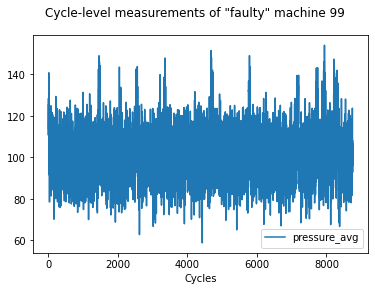

In [14]:
machine_cycles_df = aggregate_cycles(faulty_machine_sequence_df)
machine_cycles_df[['pressure_avg',
             'pressure_max']].toPandas().plot(subplots=True,
                                              title='Cycle-level measurements of "faulty" machine {}'.format(faultyMachineID))
plt.xlabel('Cycles')
plt.show()

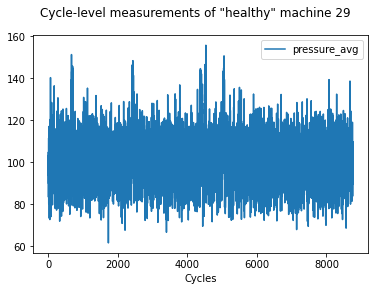

In [15]:
machine_cycles_df = aggregate_cycles(healthy_machine_sequence_df)
machine_cycles_df[['pressure_avg',
             'pressure_max']].toPandas().plot(subplots=True,
                                              title='Cycle-level measurements of "healthy" machine {}'.format(healthyMachineID))
plt.xlabel('Cycles')
plt.show()

In [16]:
cycles_df = aggregate_cycles(PdM_telemetry)
print('Total: {0} cycle(s)'.format(cycles_df.count()))\


# output geeft aan 87600 cycles, bij voorbeeld is dat 195 cycles

Total: 876000 cycle(s)


In [17]:
machine_failure_intervals_df = failure_intervals_df.where(
    F.col('machineID') == faultyMachineID)
machine_failure_intervals_df.toPandas()

,failure_timestamp,machineID,volt,rotate,pressure,vibration,model,age,failure,cycle,last_failure_timestamp
0,2015-01-02 03:00:00,99,173.235663,453.152821,129.723362,44.624581,model1,14,1,22,2000-01-01 00:00:00
1,2015-01-18 06:00:00,99,171.775481,564.542112,95.206055,51.420506,model1,14,1,409,2015-01-02 03:00:00
2,2015-02-02 06:00:00,99,174.266645,420.579042,110.596297,43.198146,model1,14,1,769,2015-01-18 06:00:00
3,2015-02-17 06:00:00,99,176.924454,370.500559,118.635348,36.686198,model1,14,1,1129,2015-02-02 06:00:00
4,2015-03-04 06:00:00,99,172.035113,392.971222,137.766297,47.642311,model1,14,1,1489,2015-02-17 06:00:00
5,2015-03-19 06:00:00,99,164.368824,540.819039,95.448221,54.026443,model1,14,1,1849,2015-03-04 06:00:00
6,2015-04-03 06:00:00,99,190.547355,400.683477,85.813203,35.814058,model1,14,1,2209,2015-03-19 06:00:00
7,2015-04-18 06:00:00,99,183.400408,420.071574,134.192475,47.140215,model1,14,1,2569,2015-04-03 06:00:00
8,2015-05-03 06:00:00,99,158.887243,416.388291,106.126688,38.160460,model1,14,1,2929,2015-04-18 06:00:00
9,2015-05-18 06:00:00,99,193.011248,447.278502,99.075683,42.187392,model1,14,1,3289,2015-05-03 06:00:00


In [18]:
df = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("datetime")))

In [19]:
train_df = df.where("rank <= .8").drop("rank")
test_df = df.where("rank > .8").drop("rank")


## Train/test split

In [20]:
# Load all csv datas using pandas
import os
import pandas as pd

WORKING_DIR = '../data/'

df_tele = pd.read_csv(WORKING_DIR + 'PdM_telemetry.csv')
df_fail = pd.read_csv(WORKING_DIR + 'PdM_failures.csv')
df_err = pd.read_csv(WORKING_DIR + 'PdM_errors.csv')
df_maint = pd.read_csv(WORKING_DIR + 'PdM_maint.csv')

In [21]:
df_sel = df_tele.loc[df_tele['machineID'] == 99].reset_index(drop=True)
df_sel.head(n=5)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692
1,2015-01-01 07:00:00,99,153.667693,441.288719,128.011446,39.271527
2,2015-01-01 08:00:00,99,178.319255,512.612661,128.526147,42.975412
3,2015-01-01 09:00:00,99,162.163821,493.356626,114.435754,40.044016
4,2015-01-01 10:00:00,99,180.201336,550.512296,110.771891,43.054530


In [22]:
# Check failure record of machine 99 and create new
sel_fail = df_fail.loc[df_fail['machineID'] == 99]
pd.DataFrame(sel_fail)

,datetime,machineID,failure
739,2015-01-02 03:00:00,99,comp3
740,2015-01-18 06:00:00,99,comp4
741,2015-02-02 06:00:00,99,comp1
742,2015-02-17 06:00:00,99,comp2
743,2015-03-04 06:00:00,99,comp3
744,2015-03-19 06:00:00,99,comp4
745,2015-04-03 06:00:00,99,comp2
746,2015-04-18 06:00:00,99,comp3
747,2015-05-03 06:00:00,99,comp2
748,2015-05-18 06:00:00,99,comp1


In [23]:
# Check error record of machine 99
sel_err = df_err.loc[df_err['machineID'] == 99] 
pd.DataFrame(sel_err).head()

,datetime,machineID,errorID
3834,2015-01-17 06:00:00,99,error5
3835,2015-01-19 07:00:00,99,error2
3836,2015-01-28 01:00:00,99,error2
3837,2015-01-30 10:00:00,99,error2
3838,2015-02-01 06:00:00,99,error1


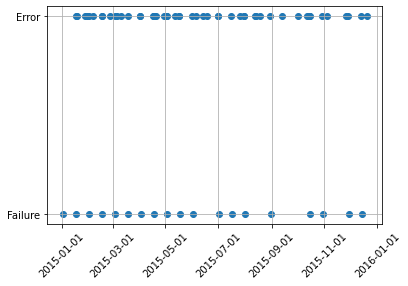

In [24]:
fig, ax = plt.subplots()

# For a simpler plot, we will use two different values in the y-axis to differentiate between error and failure
y_category = list()

for iter in range(0, len(sel_fail)):
  y_category.append('Failure')

for iter in range(0, len(sel_err)):
  y_category.append('Error')

# Get timestamp from error and selected failure
df_timestamp = pd.concat([sel_fail['datetime'], sel_err['datetime']], ignore_index=True, axis=0)
df_plot = pd.DataFrame({"timestamp": df_timestamp, "category": y_category})
df_plot.loc[:, 'timestamp'] = pd.to_datetime(df_plot.loc[:, 'timestamp'])
df_plot.sort_values(by=['timestamp'], inplace=True, ignore_index=True)


# Plot the data with timestamp as x-axis
ax.scatter('timestamp', 'category', data = df_plot)
yearfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(yearfmt)
ax.tick_params(axis='x', rotation=45)
ax.grid()

Text(0, 0.5, 'Rotation')

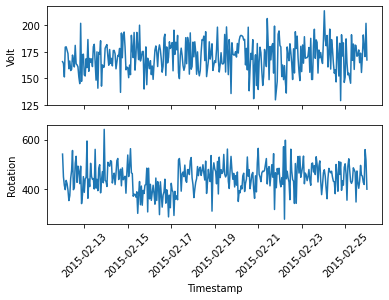

In [25]:
# Change datatype of the timestamp column from object to datetime
df_sel.loc[:, 'datetime'] = pd.to_datetime(df_sel.loc[:, 'datetime'])

# Select the date to check from failure records
st = df_sel.loc[df_sel['datetime'] == "2015-02-19"].index.values[0]

# Then, filter the telemetry data by the date and allow 7 days before and after
# the error occurs to observe any abnormalities.
select = df_sel.loc[st-7*24:st + 7*24,:]

# Plot volt and rotation feature
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot('datetime', 'volt', data=select)
ax[0].set_ylabel("Volt")

ax[1].plot('datetime', 'rotate', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Rotation")

Text(0, 0.5, 'Vibration')

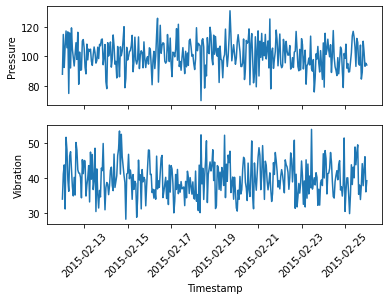

In [26]:
# Plot pressure and vibration feature
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot('datetime', 'pressure', data=select)
ax[0].set_ylabel("Pressure")

ax[1].plot('datetime', 'vibration', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Vibration")

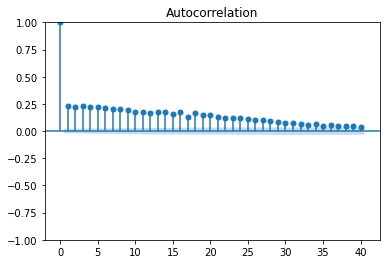

In [27]:
# Autocorrelation plot for time series
plot_acf(df_sel['pressure'], lags = 40)
plt.show()

c:\Users\ldronden\AppData\Local\pypoetry\Cache\virtualenvs\publieke-data-predictive-maintenance-6PaKd1Az-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


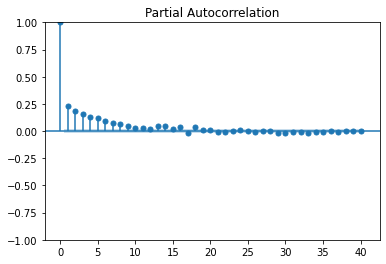

In [28]:
# Partial autocorrelation plot
plot_pacf(df_sel['pressure'], lags = 40)
plt.show()

In [31]:
# Select the date to check from failure records
st_train = df_sel.loc[df_sel['datetime'] == "2015-02-19"].index.values[0]

# Then, filter the data to include approximately one month window
start_period = st_train - 14*24
end_period = st_train + 14*24

def create_feature(start, end):
  # create features from the selected machine
  pressure = df_sel.loc[start: end, 'pressure']
  timestamp = pd.to_datetime(df_sel.loc[start: end, 'datetime'])
  timestamp_hour = timestamp.map(lambda x: x.hour)
  timestamp_dow = timestamp.map(lambda x: x.dayofweek)

  # apply one-hot encode for timestamp data
  timestamp_hour_onehot = pd.get_dummies(timestamp_hour).to_numpy()

  # apply min-max scaler to numerical data
  scaler = MinMaxScaler()
  pressure = scaler.fit_transform(np.array(pressure).reshape(-1,1))

  # combine features into one
  feature = np.concatenate([pressure, timestamp_hour_onehot], axis=1)

  X = feature[:-1]
  y = np.array(feature[5:,0]).reshape(-1,1)

  return X, y, scaler

X, y, pres_scaler = create_feature(start_period, end_period)

In [32]:
def shape_sequence(arr, step, start):
    out = list()
    for i in range(start, arr.shape[0]):
        low_lim = i
        up_lim = low_lim + step
        out.append(arr[low_lim: up_lim])

        if up_lim == arr.shape[0]:
          # print(i)
          break

    out_seq = np.array(out)
    return out_seq

# Shape the sequence according to the length specified
X_seq = shape_sequence(X, 5, 0)
y_seq = shape_sequence(y, 1, 0)

# Separate the input and output for train and validation
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print("Training data shape = ", X_train.shape)
print("Validation data shape = ", X_val.shape)

Training data shape =  (534, 5, 25)
Validation data shape =  (134, 5, 25)


## Fit model

In [33]:
random.seed(512)

def create_model(nb_units = 16):
  shape = X_train.shape[1]
  feat_length = X_train.shape[2]

  model = Sequential()
  model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=True))
  model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=False))
  model.add(Dense(shape, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer=Adam(lr=0.035),
                loss=loss.mean_squared_error)
  return model

model = create_model()
history = model.fit(X_train, y_train, verbose=1, epochs=50, validation_split = 0.1)


c:\Users\ldronden\AppData\Local\pypoetry\Cache\virtualenvs\publieke-data-predictive-maintenance-6PaKd1Az-py3.9\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
15/15 [==============================] - 3s 44ms/step - loss: 0.0772 - val_loss: 0.0161
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0259 - val_loss: 0.0186
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0180
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0167
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0181
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0224 - val_loss: 0.0167
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0225 - val_loss: 0.0173
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0208
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0163
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.0201
Epoch 11/50
15/15 

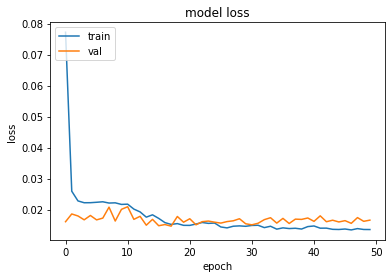

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Validation error =  0.0139645375


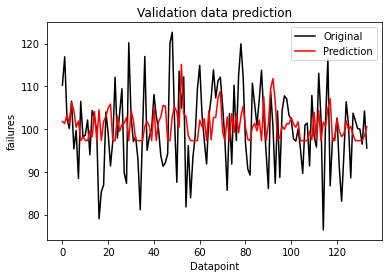

In [35]:
# Predict validation data using the trained model
y_pred = model.predict(X_val)
mse = MeanSquaredError()
val_err = mse(y_val.reshape(-1,1), y_pred)
print("Validation error = ", val_err.numpy())
# Return the value using inverse transform to allow better observation
plt.plot(pres_scaler.inverse_transform(y_val.reshape(-1,1)), 'k', label='Original')
plt.plot(pres_scaler.inverse_transform(y_pred.reshape(-1,1)), 'r', label='Prediction')
plt.ylabel("failures")
plt.xlabel("Datapoint")
plt.title("Validation data prediction")
plt.legend()
plt.show()

Mean Squared Error =  0.029696915


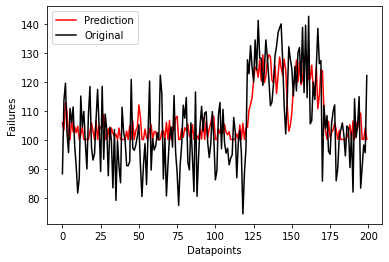

In [36]:
# Select the date where another failure occurred
st_test = df_sel.loc[df_sel['datetime'] == "2015-04-20"].index.values[0]

# Then, filter the data to include approximately two-weeks window
start_period_test = st_test - 7*24
end_period_test = st_test + 7*24
X_test, y_test, test_scaler = create_feature(start_period_test, end_period_test)

# Shape the sequence 
X_test_seq = shape_sequence(X_test, 5, 0)
y_test_seq = shape_sequence(y_test, 1, 0)

# Predict the testing data
y_pred_test = model.predict(X_test_seq)
test_err = mse(y_test_seq.reshape(-1,1), y_pred_test)
print("Mean Squared Error = ", test_err.numpy())

# Select first 200 datapoints to allow for better plotting
# Return the value using inverse transform to allow better observation
plt.plot(test_scaler.inverse_transform(y_pred_test[:200].reshape(-1, 1)), 'r', label='Prediction')
plt.plot(test_scaler.inverse_transform(y_test_seq[:200].reshape(-1, 1)), 'k', label='Original')
plt.ylabel("Failures")
plt.xlabel("Datapoints")
plt.legend()
plt.show()

In [37]:
y_pred_test


array([[0.4624241 ],
       [0.4260421 ],
       [0.56345993],
       [0.51956123],
       [0.37840006],
       [0.37840006],
       [0.47938955],
       [0.41663533],
       [0.442369  ],
       [0.41239622],
       [0.44572514],
       [0.37840006],
       [0.4019656 ],
       [0.44196397],
       [0.37840006],
       [0.37840006],
       [0.37840006],
       [0.37840006],
       [0.41953754],
       [0.4617806 ],
       [0.42023396],
       [0.37840006],
       [0.47306138],
       [0.37840006],
       [0.44965968],
       [0.4328767 ],
       [0.44085425],
       [0.50436115],
       [0.37840006],
       [0.388069  ],
       [0.43213195],
       [0.37840006],
       [0.43695942],
       [0.40986243],
       [0.39450544],
       [0.40525743],
       [0.37840006],
       [0.43619207],
       [0.37840006],
       [0.37840006],
       [0.37840006],
       [0.37840006],
       [0.42042398],
       [0.37840006],
       [0.44676578],
       [0.37840006],
       [0.4704848 ],
       [0.378